# train 2D Unet model with transfer learning. document in neptune 

## detect gpu available

In [1]:
import tensorflow as tf

# check the status of GPU
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.6.2
Num GPUs Available:  1


## set the neptune

In [2]:
# define if the documenting process should go on

DOCUMENT = False
EPOCHS = 1000
batch_size = 16
BACKBONE = 'resnet34'  # vgg, resnet, inception

In [3]:
# neptune document. change the document here

import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

if DOCUMENT:

    run = neptune.init(
        project="leeleeroy/digitalConfocal-zebrafish",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjVjOGVmZi04MjA4LTQ4N2QtOWIzYy05M2YyZWI1NzY3MmEifQ==",
        name = "UNet2D_256_transfer",
    ) # necessary credentials, the name could be used to reproduce the results 

    # for callbacks in training


    neptune_cbk = NeptuneCallback(run=run, base_namespace='metrics')  # neptune for the training process
    
    # neptune document the hyper param.

    PARAMS = {
              "optimizer": {"learning_rate": 0.0001, "optimizer": "Adam"},
              'epochs': EPOCHS,
              'batch_size':batch_size}

    # log hyper-parameters
    run['hyper-parameters'] = PARAMS
    run["sys/tags"].add([str(BACKBONE), "epochs:" + str(EPOCHS)])

## load in data and inspect with generator

### load in

In [4]:
import os 
import numpy as np
from dataGenerator_transfer import imageLoader  # tranfer learning data [NUM, W, H, CH]
import keras
import matplotlib.pyplot as plt
import glob
import random

In [5]:
# visualize func

def visusalizeIMG(n_slice, test_img, test_msk):
    # n_slice = random.randint(0, test_img.shape[2])
    plt.figure(figsize=(8, 8))

    plt.subplot(121)
    plt.imshow(test_img[n_slice,:,:], cmap='gray')
    plt.title('image')
    plt.subplot(122)
    plt.imshow(test_msk[n_slice,:,:], cmap='gray')
    plt.title('mask')
    plt.show()
    
# visualization for two images

def subShow(IMG1, IMG2):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(IMG1, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(IMG2, cmap='gray')
    plt.show()

In [6]:
# define the data path

DATA_PATH = '/home/li52/code/LM/digitalConfocal/data/zebra15/inputData/'  # use the definite path!

# training
train_img_dir = DATA_PATH + 'train/images/'
train_msk_dir = DATA_PATH + 'train/masks/'
train_img_list = sorted(os.listdir(train_img_dir))  # ensure img and msk paired
train_msk_list = sorted(os.listdir(train_msk_dir))

# testing
test_img_dir = DATA_PATH + 'test/images/'
test_msk_dir = DATA_PATH + 'test/masks/'
test_img_list = sorted(os.listdir(test_img_dir))
test_msk_list = sorted(os.listdir(test_msk_dir))

# validation
val_img_dir = DATA_PATH + 'val/images/'
val_msk_dir = DATA_PATH + 'val/masks/'
val_img_list = sorted(os.listdir(val_img_dir))
val_msk_list = sorted(os.listdir(val_msk_dir))

print('train images:', len(train_img_list))
print('val images:', len(val_img_list))
print('test images:', len(test_img_list))

train images: 240
val images: 30
test images: 30


### data generator

In [7]:
# data generator for training

from utils import *

# batch_size = 16

train_gen_class = dataGenerator_transfer(train_img_dir, train_img_list,
                               train_msk_dir, train_msk_list, batch_size)

val_gen_class = dataGenerator_transfer(val_img_dir, val_img_list,
                             val_msk_dir, val_msk_list, batch_size)


train_img_datagen = train_gen_class.imageLoader()
val_img_datagen = val_gen_class.imageLoader()

image gen: (16, 256, 256, 3) 0.0 0.984313725490196
mask gen: (16, 256, 256, 1) 0.0 1.0 [0. 1.]
slice num: 10


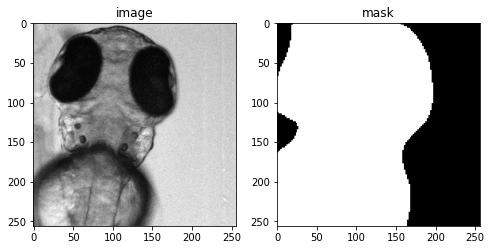

In [8]:
# visualize the data generator

img, msk = train_img_datagen.__next__()

print('image gen:', img.shape, img.min(), img.max())
print('mask gen:', msk.shape, msk.min(), msk.max(), np.unique(msk))

n_slice = random.randint(0, img.shape[0]-1)
# n_slice = 15
print('slice num:', n_slice)
visusalizeIMG(n_slice, img[...,0], msk.squeeze())

## model configuration with transfer

### 2D UNet. one channel input

In [9]:
import pandas as pd

columns = ['0', '1']
df = pd.DataFrame(columns=columns)

train_msk_list = sorted(glob.glob(train_msk_dir + '/*.npy'))

for img in range(len(train_msk_list)):
    
    # print(img)
    temp_image = np.load(train_msk_list[img])
    # temp_image = np.argmax(temp_image, axis=3)  # convert back into images
    
    val, counts = np.unique(temp_image, return_counts=True) # count labels
    zipped = zip(columns, counts)
    counts_dict = dict(zipped)
    
    df = df.append(counts_dict, ignore_index = True)

In [10]:
# calculate the ratio of different labels

label_0 = df['0'].sum()
label_1 = df['1'].sum()

total_labels = label_0 + label_1
n_classes = 2

# class weight calculated: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) # 小数点后两位
wt1 = round((total_labels/(n_classes*label_1)), 2)

print(wt0, wt1)

1.26 0.83


In [11]:
# define the optim and loss
import tensorflow.keras as K
import segmentation_models as sm

LR = 0.0001
optim = K.optimizers.Adam(LR)
wt0, wt1 = 1.26, 0.83


# loss
BCE_loss = sm.losses.BinaryCELoss()
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1]))
focal_loss = sm.losses.CategoricalFocalLoss()
# jaccard_loss = sm.losses.bce_jaccard_loss()

# total_loss = dice_loss*0.005 + (1* focal_loss) + BCE_loss*1
# total_loss = dice_loss*1 + ( focal_loss*1) + BCE_loss*0.005
total_loss = dice_loss*0.05 + (1* focal_loss) + BCE_loss*0.95

# metrics
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]
# metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

Segmentation Models: using `keras` framework.


In [12]:
# compile model

import segmentation_models as sm

sm.set_framework('tf.keras')  # ！ this serves for the sm.Unet
sm.framework()

preprocess_input = sm.get_preprocessing(BACKBONE)  # transfer comes with specific input processing

model = sm.Unet(BACKBONE, encoder_weights='imagenet')

# model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])  # bce is differentiable
model.compile(optimizer=optim, loss=total_loss, metrics=metrics)

# print(model.summary())
print('input shape:', model.input_shape)  # image input should be 3 channels, mask should be 1 channel
print('output shape:', model.output_shape)

2022-08-19 00:59:25.340736: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-19 00:59:26.158691: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30998 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0


input shape: (None, None, None, 3)
output shape: (None, None, None, 1)


## train

In [13]:
import tensorflow.keras as k

# steps and epochs
steps_per_epoch = len(train_img_list) // batch_size
val_steps_per_epoch = len(val_img_list) // batch_size

print('train steps/epoch', steps_per_epoch)
print('val steps/epoch', steps_per_epoch)

# call backs for documentation

if DOCUMENT:
    callbacks = [
        # k.callbacks.EarlyStopping(patience=15, monitor='val_loss'),
        neptune_cbk, 
        k.callbacks.TensorBoard(log_dir = './tensorboard/UNet2D_transfer')  # save in new folder in hemera. Also update in neptune
    ]
else:
    callbacks = [
        # k.callbacks.EarlyStopping(patience=15, monitor='val_loss'),
        k.callbacks.TensorBoard(log_dir = './tensorboard/UNet2D_transfer')  
    ]

train steps/epoch 15
val steps/epoch 15


2022-08-19 00:59:36.103646: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-19 00:59:36.103675: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-08-19 00:59:36.103785: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-08-19 00:59:36.104204: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /trinity/shared/pkg/numlib/mpfr/3.1.4/lib:/trinity/shared/pkg/numlib/mpc/1.0.3/lib:/trinity/shared/pkg/numlib/gmp/6.1.2/lib:/trinity/shared/pkg/compiler/gcc/7.3.0/lib64:/trinity/shared/pkg/compiler/gcc/7.3.0/lib:/trinity/shared/pkg/devel/cuda/11.2/lib64:/trinity/shared/pkg/devel/cuda/11.2/lib:/trinity/shared/pkg/devel/anaconda/2021.11/lib:/trinity/shared/pkg/devel/python/3.10.4/lib/python3.10:/trinity/shared/pkg/d

In [14]:
# # 测试用
# # train per steps. inspect the loss is correct.
# # caution, this training will continue


# # 维度变成3

# img, msk = train_img_datagen.__next__()
# print('image gen:', img.shape, img.min(), img.max())
# print('mask gen:', msk.shape, msk.min(), msk.max(), np.unique(msk))

# NUM_STEPS = 2000

# for step in range(NUM_STEPS):
    
#     img, msk = train_img_datagen.__next__()
    
#     # print(msk.shape, img.shape)
    
#     loss = model.train_on_batch(img, msk.astype('float64'))  # batch=1
    
#     print(step, loss)
    
# #     if step % 1000:
# #         model.save_weights('./model_savedG.hdf5')
        
#     if step % 100 == 0:
#         prediction = model.predict(img, batch_size=1)
#         plt.imshow(prediction[0,...],cmap='gray')
#         plt.show()
#         plt.close('all')
        

In [ ]:
# train with keras model

EPOCHS = 5  # for test

history = model.fit(train_img_datagen,
                   steps_per_epoch=steps_per_epoch,
                   epochs=EPOCHS,
                   verbose=1, # ??
                   validation_data=val_img_datagen,
                   validation_steps=val_steps_per_epoch,
                   callbacks=callbacks)

/home/li52/.conda/envs/LM/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-08-19 00:59:44.574789: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-08-19 00:59:49.526910: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


 2/15 [===>..........................] - ETA: 2s - loss: 0.8265 - accuracy: 0.4665 - iou_score: 0.2385  

2022-08-19 00:59:53.123103: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-19 00:59:53.123140: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-08-19 00:59:53.123275: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2022-08-19 00:59:53.219098: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-08-19 00:59:53.219358: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1757] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2022-08-19 00:59:53.231799: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-08-19 00:59:53.235750: I tensorflow

15/15 [==============================] - 11s 166ms/step - loss: 0.6713 - accuracy: 0.6129 - iou_score: 0.4195 - val_loss: 0.7065 - val_accuracy: 0.5329 - val_iou_score: 0.4352
Epoch 2/5
15/15 [==============================] - 1s 100ms/step - loss: 0.4706 - accuracy: 0.8518 - iou_score: 0.7725 - val_loss: 0.7052 - val_accuracy: 0.5199 - val_iou_score: 0.4777
Epoch 3/5
15/15 [==============================] - 1s 98ms/step - loss: 0.3644 - accuracy: 0.9272 - iou_score: 0.8857 - val_loss: 0.7277 - val_accuracy: 0.4620 - val_iou_score: 0.3555
Epoch 4/5
15/15 [==============================] - 1s 98ms/step - loss: 0.3083 - accuracy: 0.9518 - iou_score: 0.9227 - val_loss: 0.7122 - val_accuracy: 0.4824 - val_iou_score: 0.2170
Epoch 5/5
15/15 [==============================] - 1s 97ms/step - loss: 0.2858 - accuracy: 0.9492 - iou_score: 0.9189 - val_loss: 0.7166 - val_accuracy: 0.4656 - val_iou_score: 0.1693


In [16]:
MODEL_PATH = './models_weight/'
SVAED_MODEL_NAME = MODEL_PATH + 'transfer2D_256' + '_' + str(EPOCHS) + '.hdf5'

model.save(SVAED_MODEL_NAME)

### visualize the train process

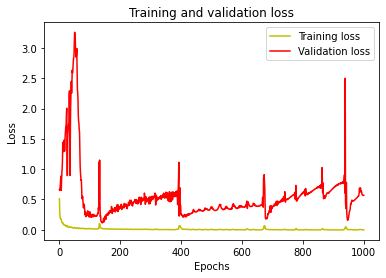

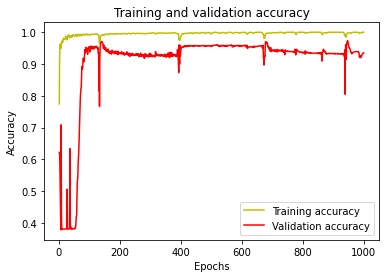

In [17]:
# visualize

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# predict on test dataset

In [18]:
# load in the model

MODEL_PATH = './models_weight/'

from keras.models import load_model
my_model = load_model(SVAED_MODEL_NAME, compile=False)

### generator for test

In [12]:
# test generator

from utils import *

batch_size_test = 32


test_gen_class = dataGenerator_transfer(test_img_dir, test_img_list,
                               test_msk_dir, test_msk_list, batch_size_test)

test_img_datagen = test_gen_class.imageLoader()

image gen: (30, 256, 256, 3) 0.0 1.0
mask gen: (30, 256, 256, 1) 0.0 1.0 [0. 1.]
slice num: 8


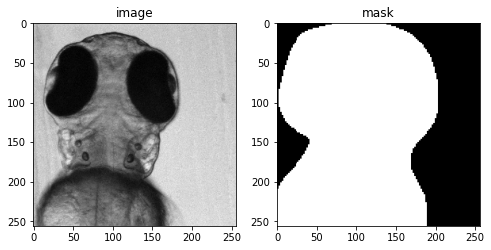

In [13]:
# inspect generator data

img_test, msk_test = test_img_datagen.__next__()

print('image gen:', img_test.shape, img_test.min(), img_test.max())
print('mask gen:', msk_test.shape, msk_test.min(), msk_test.max(), np.unique(msk_test))

n_slice = random.randint(0, img_test.shape[0]-1)
# n_slice = 15
print('slice num:', n_slice)
visusalizeIMG(n_slice, img_test, msk_test)

### predict

In [21]:
# prediction

pred_test = model.predict(img_test)
print(pred_test.shape, pred_test.min(), pred_test.max())


(30, 256, 256, 1) 3.1913708e-10 1.0


slice num: 17


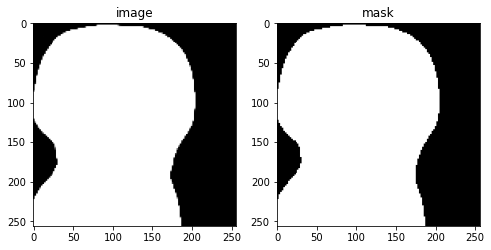

In [22]:
# visualization

n_slice = random.randint(0, pred_test.shape[0]-1)
# n_slice = 15
print('slice num:', n_slice)
visusalizeIMG(n_slice, pred_test.squeeze(), msk_test)

In [23]:
# calculate the IOU for one test batch

from tensorflow.keras.metrics import MeanIoU

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)

# pred_test_argmax = pred_test.squeeze()
IOU_keras.update_state(pred_test.squeeze(), msk_test)
print("pred Mean IoU =", IOU_keras.result().numpy())

pred Mean IoU = 0.23237845


### document the test result

255.0


(-0.5, 797.5, 255.5, -0.5)

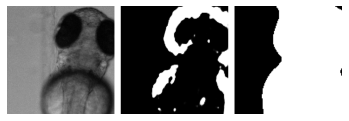

In [24]:
# test one image

i = 9

tIMG = img_test[...,0][i,...] # input
tPred = pred_test.squeeze()[i,...] # prediction
tMask = msk_test.squeeze()[i,...] # GT

bar = np.ones((tIMG.shape[0], 15))   # lines
combTemp = np.concatenate((tIMG, bar, tPred, bar, tMask), axis=1) * 255

print(combTemp.max())

plt.imshow(combTemp, cmap='gray')
plt.axis('off')

In [25]:
# document in neptune

for i in range(pred_test.shape[0]):
    tIMG = img_test[...,0][i,...] # input
    tPred = pred_test.squeeze()[i,...] # prediction
    tMask = msk_test.squeeze()[i,...] # GT
    
    bar = np.ones((tIMG.shape[0], 15))   # lines
    combTemp = np.concatenate((tIMG, bar, tPred, bar, tMask), axis=1) # upload [0, 1]
    
    
    # upload the test images to neptune
    if DOCUMENT:
        # upload the test results into neptune with handle 'description'
        run["test/sample_images"].log(neptune.types.File.as_image(combTemp), name=str(i), description='test images')  
    

## stop neptune

In [26]:
# stop the neptune
if DOCUMENT:
    run.stop() 

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 47 operations to synchronize with Neptune. Do not kill this process.


All 47 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/leeleeroy/digitalConfocal-zebrafish/e/DIGZ-12


## predict a whole stack

### load in the image stacks

In [27]:
# load in

preSegStacks = np.load('/bigdata/casus/MLID/RuiLi/Data/LM/segStacks/segStacks_170411_24.npy')
print(preSegStacks.shape, preSegStacks.min(), preSegStacks.max())

(4, 20, 256, 256) 0 255


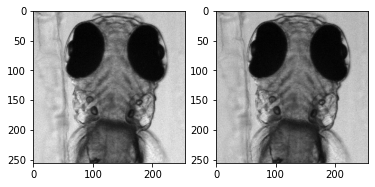

In [28]:
# visualize
import random

n_slice = random.randint(0, preSegStacks.shape[1])
subShow(preSegStacks[0,n_slice,:,:,], preSegStacks[0,n_slice + 1,:,:,])

### predict in model

In [29]:
# predict per stacks

predictStacks = []

for stack in range(preSegStacks.shape[0]):
    stackTemp = preSegStacks[stack,...] / 255 # uint8 -> [0, 1]
    stackTemp = np.stack([stackTemp,stackTemp,stackTemp], axis=-1)  # transfer, 3 channels
    predTemp = model.predict(stackTemp)
    
    predictStacks.append(predTemp.squeeze())
    
predictStacks = np.asarray(predictStacks)
print(predictStacks.shape, predictStacks.min(), predictStacks.max())

(4, 20, 256, 256) 3.1410546e-10 1.0


slice num: 14


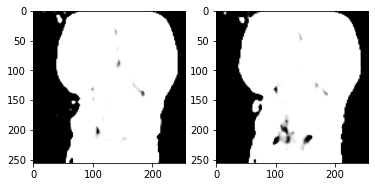

In [30]:
# visualize

n_slice = random.randint(0, predictStacks.shape[1]-1)
print('slice num:', n_slice)
subShow(predictStacks[0,n_slice,:,:,], predictStacks[0,n_slice + 1,:,:,])

### take seg pixels from mask

In [31]:
# seg one stack images [NUM, W, H]. msk as bool, img as [0, 1]

import numpy as np

def segPixels(mskStack, imgStack):
    
    segStack = []
    for num in range(mskStack.shape[0]):
        
        mskTemp = mskStack[num,...]
        imgTemp = imgStack[num,...]
        
        segTemp = np.zeros(imgTemp.shape)
        # print(mskTemp.shape)
        
        posTemp = np.where(mskTemp)

        for i in range(posTemp[0].shape[0]):
            segTemp[posTemp[0][i],posTemp[1][i]] = imgTemp[posTemp[0][i],posTemp[1][i]]
        
        segStack.append(segTemp)
        
    return np.asarray(segStack)
    

slice num: 2


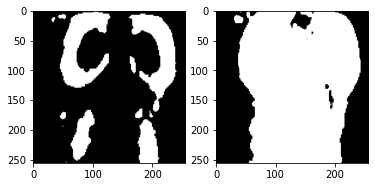

In [32]:
# binarize the mask stacks

predictStacks = predictStacks > 0.2

n_slice = random.randint(0, predictStacks.shape[1]-1)
print('slice num:', n_slice)
subShow(predictStacks[0,n_slice,:,:,], predictStacks[0,n_slice + 1,:,:,])

In [33]:
# seg all stacks

segStacks = []

for stack in range(predictStacks.shape[0]):
    
    tempMskStack = predictStacks[stack]
    tempImgStack = preSegStacks[stack]
    
    tempSegStack = segPixels(tempMskStack, tempImgStack)
    
    segStacks.append(tempSegStack)

segStacks = np.asarray(segStacks)
print(segStacks.shape)

(4, 20, 256, 256)


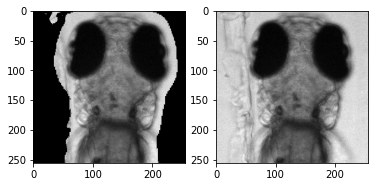

In [34]:
# visualize
import random

n_stack = 0
n_slice = random.randint(0, segStacks.shape[1]-1)

subShow(segStacks[n_stack, n_slice, :, :], preSegStacks[n_stack, n_slice, :, :])

### save image for offline visualize

In [35]:
# save as tif for offline visualize

import numpy as np
from tifffile import imsave

SEG_PATH = './reports/UNet2D_transfer/'

for stack in range(segStacks.shape[0]):
    
    tempStack = segStacks[stack,...]   
    imsave(SEG_PATH + str(stack) +'_seg_result' + '.tif', tempStack)